# Identifying most prominent nodes in social network for Information Diffusion by Weak Nodes approach

## Deepak Khirey
### Network Science, Indiana Unversity, Bloomington, Spring 2019

In [2]:
# importing required package and libraries

import networkx as nx
import community
import networkx as nx
import random
import time
import datetime
import io
import array,re,itertools
import numpy as np
import pandas as pd
import sampling
import scipy.stats as stats
from heapq import nlargest
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Reading input graph TVShows
tvshows=nx.read_graphml('tvshows.graphml')

In [4]:
print(nx.info(tvshows))

Name: 
Type: Graph
Number of nodes: 3892
Number of edges: 17239
Average degree:   8.8587


In [5]:
# Method to get sample from input graph.
# I am using snowball sampling method.
# Returns sample of the graph

def getsample(G,n=100):
    snwbl = sampling.Snowball()
    sample = snwbl.snowball(G,n,5)
    return sample

In [6]:
# Method to generate CCDF plot for input graph
# This will show scale free properties in the graph, if present

def ccdf(data):
    ## Function referrence - https://stackoverflow.com/questions/24575869/read-file-and-plot-cdf-in-python
    data_size=len(data)

    # Set bins edges
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)

    counts=counts.astype(float)/data_size

    # Find the cdf
    cdf = np.cumsum(counts)
    ccdf = 1 - cdf

    # Plot the cdf
    plt.loglog(bin_edges[0:-1], ccdf,linestyle='--', marker="o", color='b')
    plt.ylim((0,1))
    plt.ylabel("CCDF")
    plt.grid(True)

    plt.show()

In [7]:
# Method to detect community structure in the input graph
# I am using Modularity approach here 
# r : Resolution to be used for Modularity
# Returns partitions of the graph

def getcommunities (G,r):
    part = community.best_partition(G,resolution=r,randomize=True)
    mod = community.modularity(part,G)
    nx.set_node_attributes(G,part, "Modularity Class")
    return part

In [8]:
# Method to calculate Betweenness centrality for th input graph
# Returns array with nodes and their corresponding betweenness values

def getcentrality(G):
    betweenness = nx.betweenness_centrality(G)
    nx.set_node_attributes(G,betweenness, "Betweenness")
    return betweenness

In [9]:
#Method to write graph file to the OS

def write_graph(G,name):
    nx.write_gexf(G,name)

In [10]:
# Method to identify weak nodes from the partitions
# weak nodes are those which connect different communities
# Returns list of weak nodes

def getweaknode(G,partition) :
    weak_nodes = []
    for edge in G.edges():
        if (partition.get(edge[0])!= partition.get(edge[1])): 
            weak_nodes.append(edge[0])
            weak_nodes.append(edge[1])
    return weak_nodes

In [11]:
# Method to identify top node from input graph
# n : number of top nodes to be selected
# Returns number of top nodes as required

def gettopnodes(G,n,r=2.0):
    part = getcommunities(G,r)
    weak_nodes = getweaknode(G,part)  
    subdict = {node: G.degree(node) for node in weak_nodes}
    top=nlargest(n, subdict, key=subdict.get)
    return top

In [12]:
# Method to identify unique nodes at geodesic distance =2 from selected node
# returns count of unique nodes

def getksquare(G,top):
    nb = set()
    [[[nb.add(m) for m in G.neighbors(n)] for n in G.neighbors(node)] for node in top]
    colors = {n:177 if n in top else 114 if n in nb-set(top) else 110 for n in G.nodes()}
    nx.set_node_attributes(G,colors,"color")
    sizes = {n:30.00 if n in top else 20.00 if n in nb-set(top) else 10.00 for n in G.nodes()}
    nx.set_node_attributes(G,sizes,"size")
    return len(nb)

In [13]:
# Method to identify unique nodes at geodesic distance =1 from selected node
# returns count of unique nodes

def getknodes(G,top):
    nb = set()
    [[nb.add(n) for n in G.neighbors(node)] for node in top]
    return len(nb)

In [14]:
# Method to select top nodes by betweenness value
# n : number of top nodes to be selected
# Returns list of weak nodes

def topbetweennessnodes(G,n):
    betweenness = getcentrality(G)
    subdict = {node: betweenness[node] for node in G.nodes()}
    top=nlargest(n, subdict, key=subdict.get)
    return top

In [15]:
# Method for 2-sided statistic test
# This compare 2 input arrays and based on t-stats and p-value prints better method

def statstest(model1,model2):
    (t_stat, p_value) = stats.ttest_rel(model1, model2)
    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two methods (Accept H0)\n(t_stat, p_value) = (%.2f, %.9f)'%(t_stat, p_value))
    else:
        print('The two methods are different (reject H0) \n(t_stat, p_value) = (%.2f, %.9f)'%(t_stat, p_value) )
        if t_stat > 0.0: 
            print('Weak nodes method is better than Betweenness method')
        else:
            print('Betweenness method is better than Weak nodes method')

In [16]:
# Method to simulate configuration model in input graph degree sequence
# This is also umberella method to run statistical test repetitively

def configmodel(G,iter,topn):
    degree_sequence = list(dict(nx.degree(G)).values())

    # We need to generate enough null graphs to make a reasonable assessment of the null distribution
    model = []
    modelk = []
    modelbetween = []
    modelbetweenk = []
    summary = []
    for i in range(iter):
        # Use the configuration model to create a null graph
        null_graph = nx.configuration_model(degree_sequence)
    
        # We need to remove self-loops and parallel edges because they don't make
        # sense in this social network
        null_graph = nx.Graph(null_graph) # removes parallel edges
        null_graph.remove_edges_from(null_graph.selfloop_edges()) # removes self-loops
    
        top = gettopnodes(null_graph,topn)
        model.append(getksquare(null_graph,top))
        modelk.append(getknodes(null_graph,top))
        
        # Calculate the model's assortativity and add it to the list
        topbet = topbetweennessnodes(null_graph,topn)
        modelbetween.append(getksquare(null_graph,topbet))
        modelbetweenk.append(getknodes(null_graph,topbet))

    statstest(model,modelbetween)
    summary = [np.mean(model),np.mean(modelk),np.mean(modelbetween),np.mean(modelbetweenk)]
    return summary

In [17]:
# Running both methods on sample size 500 and selecting top 5 nodes

s= 500
sample = getsample(tvshows,n=s)
top = gettopnodes(sample,5)
getksquare(sample,top)
getknodes(sample,top)
write_graph(sample,"tvshows_sample_"+str(s)+"pptweakocc.gexf")
topbet = topbetweennessnodes(sample,5)
getksquare(sample,topbet)
getknodes(sample,topbet)
write_graph(sample,"tvshows_sample_"+str(s)+"pptbetocc.gexf")

In [18]:
# Running both methods on sample size 500 and selecting top 5,10,15,20 nodes

topn = [5,10,15,20]
s= 500
sample = getsample(tvshows,n=s)
for t in topn :
    print("--------------------",t,"--------------------")
    top = gettopnodes(sample,t)
    getksquare(sample,top)
    getknodes(sample,top)
    topbet = topbetweennessnodes(sample,t)
    getksquare(sample,topbet)
    getknodes(sample,topbet)

-------------------- 5 --------------------
-------------------- 10 --------------------
-------------------- 15 --------------------
-------------------- 20 --------------------


In [19]:
# Running both methods on sample size 100 to 1000 and selecting top 5 nodes

sample_size = [100,200,300,400,500,600,700,800,900,1000]
summarylist = []
for s in sample_size:
    summary = []
    print("--------------------",s,"--------------------")
    sample = getsample(tvshows,n=s)
    print(nx.info(sample))
    summary = configmodel(sample,100,5)
    print(summary)
    summarylist.append(summary)
print(summarylist)

-------------------- 100 --------------------
Name: 
Type: Graph
Number of nodes: 104
Number of edges: 187
Average degree:   3.5962
The two methods are different (reject H0) 
(t_stat, p_value) = (-5.63, 0.000000167)
Betweenness method is better than Weak nodes method
[78.81, 40.6, 80.82, 40.36]
-------------------- 200 --------------------
Name: 
Type: Graph
Number of nodes: 201
Number of edges: 363
Average degree:   3.6119
The two methods are different (reject H0) 
(t_stat, p_value) = (-5.80, 0.000000081)
Betweenness method is better than Weak nodes method
[117.3, 45.73, 120.54, 44.91]
-------------------- 300 --------------------
Name: 
Type: Graph
Number of nodes: 301
Number of edges: 505
Average degree:   3.3555
The two methods are different (reject H0) 
(t_stat, p_value) = (-6.44, 0.000000004)
Betweenness method is better than Weak nodes method
[144.62, 49.21, 150.62, 47.77]
-------------------- 400 --------------------
Name: 
Type: Graph
Number of nodes: 404
Number of edges: 856


In [20]:
result = pd.DataFrame(data=summarylist, columns=["weaknode_k2","weaknode_k","betweenness_k2","betweenness_k"])
result

,weaknode_k2,weaknode_k,betweenness_k2,betweenness_k
0,78.81,40.60,80.82,40.36
1,117.30,45.73,120.54,44.91
2,144.62,49.21,150.62,47.77
3,229.66,72.39,233.96,71.76
4,286.15,82.79,291.70,82.38
5,304.57,80.84,314.61,79.58
6,369.32,100.51,377.40,98.90
7,427.68,109.65,436.84,108.78
8,494.46,117.89,501.36,116.65
9,490.58,115.51,499.77,114.53


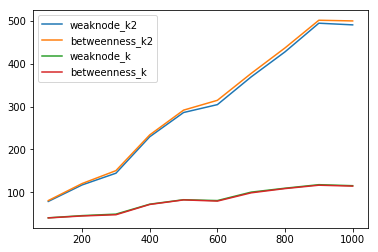

In [21]:
plt.plot(sample_size,result["weaknode_k2"])
plt.plot(sample_size,result["betweenness_k2"])

plt.plot(sample_size,result["weaknode_k"])
plt.plot(sample_size,result["betweenness_k"])

plt.legend()

In [201]:
# Running both methods on different networks in GEMSEC dataset

graphs = ["tvshows.graphml","politician.graphml","company.graphml","publicfigures.graphml","government.graphml","atheletes.graphml","newsites.graphml"]
resolutions = {"tvshows.graphml":2,"politician.graphml":2,"company.graphml":3,"publicfigures.graphml":2,"government.graphml":3,"atheletes.graphml":3,"newsites.graphml":1}

result = []
for gml in graphs:
    print("--------------------",gml,"--------------------")
    counts = []
    G = nx.read_graphml(gml)
    G = nx.Graph(G)
    print(nx.info(G))
    communities5 = gettopnodes(G,5,r=resolutions[gml])
    communitiescount = getksquare(G,communities5)
    counts.append(communitiescount)
    between5 = topbetweennessnodes(G,5)
    betweencount = getksquare(G,between5)
    counts.append(betweencount)
    print(counts)
    result.append(counts)
print(result)

-------------------- tvshows.graphml --------------------
[1094, 1212]
-------------------- politician.graphml --------------------
[3197, 3277]
-------------------- company.graphml --------------------
[4830, 4773]
-------------------- publicfigures.graphml --------------------
[6583, 6583]
-------------------- government.graphml --------------------
[5040, 5039]
-------------------- atheletes.graphml --------------------
[7871, 7896]
-------------------- newsites.graphml --------------------
[14735, 15374]
[[1094, 1212], [3197, 3277], [4830, 4773], [6583, 6583], [5040, 5039], [7871, 7896], [14735, 15374]]


In [202]:
resultdf = pd.DataFrame(data=result, columns=["weaknode_k2","betweenness_k2"],index=graphs)
resultdf

,commk2,betk2
0,1094,1212
1,3197,3277
2,4830,4773
3,6583,6583
4,5040,5039
5,7871,7896
6,14735,15374


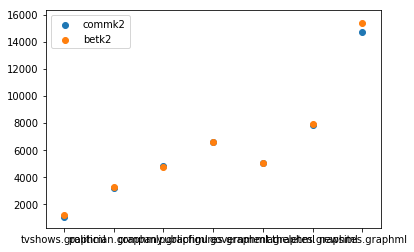

In [203]:
plt.scatter(graphs,resultdf["weaknode_k2"])
plt.scatter(graphs,resultdf["betweenness_k2"])

plt.legend()